# Interactions - Lab

## Introduction

In this lab, you'll explore interactions in the Ames Housing dataset.

## Objectives

You will be able to:
- Implement interaction terms in Python using the `sklearn` and `statsmodels` packages 
- Interpret interaction variables in the context of a real-world problem 

## Build a baseline model 

You'll use a couple of built-in functions, which we imported for you below: 

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

If you still want to build a model in the end, you can do that, but this lab will just focus on finding meaningful insights in interactions and how they can improve $R^2$ values.

In [2]:
regression = LinearRegression()

Create a baseline model which includes all the variables we selected from the Ames housing data set to predict the house prices. Then use 10-fold cross-validation and report the mean $R^2$ value as the baseline $R^2$.

In [3]:
ames = pd.read_csv('ames.csv')

continuous = ['LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']
categoricals = ['BldgType', 'KitchenQual', 'SaleType', 'MSZoning', 'Street', 'Neighborhood']

ames_cont = ames[continuous]

# log features
log_names = [f'{column}_log' for column in ames_cont.columns]

ames_log = np.log(ames_cont)
ames_log.columns = log_names

# normalize (subract mean and divide by std)

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

ames_log_norm = ames_log.apply(normalize)

# one hot encode categoricals
ames_ohe = pd.get_dummies(ames[categoricals], prefix=categoricals)

preprocessed = pd.concat([ames_cont, ames_ohe], axis=1)

X = preprocessed.drop('SalePrice', axis=1)
y = preprocessed['SalePrice']

In [4]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))

baseline

0.7773817128043183

## See how interactions improve your baseline

Next, create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the $R^2$. We'll look at the 3 interactions which have the biggest effect on our $R^2$, so print out the top 3 combinations.

You will create a `for` loop to loop through all the combinations of 2 predictors. You can use `combinations` from itertools to create a list of all the pairwise combinations. To find more info on how this is done, have a look [here](https://docs.python.org/2/library/itertools.html).

Since there are so many different neighbourhoods we will exclude

In [5]:
from itertools import combinations

In [6]:
# code to find top interactions by R^2 value here
interactions = []
feat_combinations = combinations(X.columns, 2)
data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a]*data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    if score > baseline: interactions.append((a, b, round(score, 3)))

In [7]:
sorted(interactions, key=lambda x: -x[2])[:3]

[('LotArea', 'Neighborhood_Edwards', 0.809),
 ('GrLivArea', 'Neighborhood_Edwards', 0.808),
 ('1stFlrSF', 'Neighborhood_Edwards', 0.803)]

It looks like the top interactions involve the Neighborhood_Edwards feature so lets add the interaction between LotArea and Edwards to our model.

We can interpret this feature as the relationship between LotArea and SalePrice when the house is in Edwards or not.

## Visualize the Interaction

Separate all houses that are located in Edwards and those that are not. Run a linear regression on each population against `SalePrice`. Visualize the regression line and data points with price on the y axis and LotArea on the x axis.

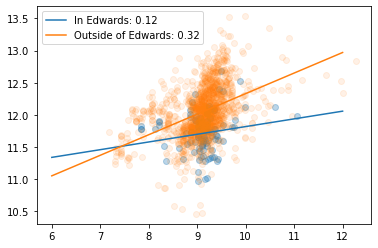

In [8]:
# Visualization code here
x = np.linspace(6, 12)

is_in = np.log(preprocessed[preprocessed.Neighborhood_Edwards==1][['LotArea', 'SalePrice']])
linreg = LinearRegression()
linreg.fit(is_in[['LotArea']], is_in.SalePrice)
plt.scatter(is_in.LotArea, is_in.SalePrice, alpha=.3)
plt.plot(x, linreg.predict(x[:, None]), label=f'In Edwards: {linreg.coef_[0]:.2f}')

not_in = np.log(preprocessed[preprocessed.Neighborhood_Edwards==0][['LotArea', 'SalePrice']])
linreg = LinearRegression()
linreg.fit(not_in[['LotArea']], not_in.SalePrice)
plt.scatter(not_in.LotArea, not_in.SalePrice, alpha=.1)
plt.plot(x, linreg.predict(x[:, None]), label=f'Outside of Edwards: {linreg.coef_[0]:.2f}')

plt.legend()

## Build a final model with interactions

Use 10-fold cross-validation to build a model using the above interaction. 

In [9]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
final = X.copy()
final['Neighborhood_Edwards*LotArea'] = final['Neighborhood_Edwards']*final['LotArea']
final_model = np.mean(cross_val_score(regression, final, y, scoring='r2', cv=crossvalidation))
final_model

0.8093297306636977

Our $R^2$ has increased considerably! Let's have a look in `statsmodels` to see if this interactions are significant.

In [10]:
import statsmodels.api as sm

df_inter_sm = sm.add_constant(final)
model = sm.OLS(y, final)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     148.6
Date:                Sun, 06 Dec 2020   Prob (F-statistic):               0.00
Time:                        02:03:46   Log-Likelihood:                -17229.
No. Observations:                1460   AIC:                         3.456e+04
Df Residuals:                    1411   BIC:                         3.482e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
LotArea                          0.6108      0.103      5.916      0.000       0.408       0.813
1stFlrSF                        35.0664      3.288     10.664      0.000      28.616      41.517
GrLivArea                       58.1426      2.405     24.171      0.000      53.424      62.861
BldgType_1Fam                 2.922e+04   2902.954     10.066      0.000    2.35e+04    3.49e+04
BldgType_2fmCon               1.242e+04   5897.809      2.105      0.035     847.853     2.4e+04
BldgType_Duplex              -3641.5299   4775.013     -0.763      0.446    -1.3e+04    5725.358
BldgType_Twnhs               -7057.2521   5689.576     -1.240      0.215   -1.82e+04    4103.687
BldgType_TwnhsE               5879.6997   3832.141      1.534      0.125   -1637.606    1.34e+04
KitchenQual_Ex                6.041e+04   4203.276     14.371      0.000    5.22e+04    6.87e+04
KitchenQual_Fa               -2.033e+04   4811.017     -4.225      0.000   -2.98e+04   -1.09e+04
KitchenQual_Gd                6309.0317   2725.293      2.315      0.021     962.969    1.17e+04
KitchenQual_TA               -9568.2577   2512.797     -3.808      0.000   -1.45e+04   -4639.037
SaleType_COD                 -1.616e+04   6414.150     -2.519      0.012   -2.87e+04   -3575.093
SaleType_CWD                  5095.8845   1.54e+04      0.330      0.741   -2.52e+04    3.54e+04
SaleType_Con                  4.676e+04   2.18e+04      2.149      0.032    4071.965    8.95e+04
SaleType_ConLD                 267.8450   1.11e+04      0.024      0.981   -2.14e+04    2.19e+04
SaleType_ConLI                 888.5698   1.39e+04      0.064      0.949   -2.64e+04    2.82e+04
SaleType_ConLw               -5236.1620    1.4e+04     -0.375      0.708   -3.26e+04    2.22e+04
SaleType_New                  1.611e+04   5396.453      2.986      0.003    5528.209    2.67e+04
SaleType_Oth                 -7445.4890   1.76e+04     -0.423      0.673    -4.2e+04    2.71e+04
SaleType_WD                  -3470.6182   4492.513     -0.773      0.440   -1.23e+04    5342.104
MSZoning_C (all)             -1.649e+04   1.06e+04     -1.553      0.121   -3.73e+04    4333.248
MSZoning_FV                    2.15e+04   7819.714      2.749      0.006    6156.896    3.68e+04
MSZoning_RH                   1565.0621   8028.716      0.195      0.845   -1.42e+04    1.73e+04
MSZoning_RL                   1.276e+04   3975.156      3.210      0.001    4963.351    2.06e+04
MSZoning_RM                   1.748e+04   4540.010      3.851      0.000    8578.857    2.64e+04
Street_Grvl                   2.003e+04   1.02e+04      1.961      0.050      -1.589    4.01e+04
Street_Pave                   1.679e+04   5572.202      3.012      0.003    5855.136    2.77e+04
Neighborhood_Blmngtn          1.084e+04   8819.610      1.229      0.219   -

What is your conclusion here?

In [11]:
# formulate your conclusion

## Summary

You should now understand how to include interaction effects in your model! As you can see, interactions can have a strong impact on linear regression models, and they should always be considered when you are constructing your models.